In [ ]:
import pandas as pd
import rasterio
import rasterio.merge
from rasterio.plot import show
import warnings
warnings.filterwarnings("ignore", category=rasterio.errors.NotGeoreferencedWarning)
import numpy as np

import matplotlib.pyplot as plt
import os
import os.path
from pathlib import Path
import glob
import random
from PIL import Image
import shutil

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.decomposition import PCA

In [ ]:
import zipfile
path = 'landuse-scene-classification' #this is be the path of the target directory
if not os.path.exists(path): 
    #Will only execute if the target directory doesn't already exist, as to avoid repeatedly unzipping this file
    with zipfile.ZipFile('UCMerced_LandUse.zip', 'r') as zip_ref:
        zip_ref.extractall(path)
    print("\'UCMerced_LandUse.zip\' was extracted.")
    print(f"All images are located in the designated directory, \'{path}\'")
else:
    print("Path already exists. No zip extraction neccessary")

Path already exists. No zip extraction neccessary


In [ ]:
class_names = ["agricultural","airplane","baseballdiamond","beach",
 "buildings","chaparral","denseresidential","forest","freeway","golfcourse","harbor",
 "intersection","mediumresidential","mobilehomepark","overpass",
 "parkinglot","river","runway","sparseresidential","storagetanks","tenniscourt"]

train_image_path = glob.glob('landuse-scene-classification/Train/*.tif', recursive = True)
test_image_path = glob.glob('landuse-scene-classification/Test/*.tif', recursive = True)
#train_image_path & and test_image_path are lists of strings that lay out the path to every image

random.shuffle(train_image_path) #Ensures that the image pathways are listed in a random order
random.shuffle(test_image_path)
    
train_labels = list(map(lambda x: ((x.partition("Train\\")[2]).split('.tif')[0])[:-2],train_image_path))
test_labels = list(map(lambda x: ((x.partition("Test\\")[2]).split('.tif')[0])[:-2],test_image_path))

def display_image_count(): #This function displays how many images are in each category of training and testing datasets
    print("\n\033[1mTrain Image Count:\033[0m\n------------------")
    for labels in class_names:
        print(f"{labels}: ", train_labels.count(labels))

    print("\n\033[1mTest Image Count:\033[0m\n------------------")   
    for labels in class_names:
        print(f"{labels}: ", test_labels.count(labels))

display_image_count()


Train Image Count:
------------------
agricultural:  80
airplane:  77
baseballdiamond:  77
beach:  79
buildings:  80
chaparral:  80
denseresidential:  80
forest:  80
freeway:  80
golfcourse:  76
harbor:  78
intersection:  80
mediumresidential:  80
mobilehomepark:  76
overpass:  70
parkinglot:  78
river:  79
runway:  79
sparseresidential:  77
storagetanks:  77
tenniscourt:  78

Test Image Count:
------------------
agricultural:  20
airplane:  20
baseballdiamond:  19
beach:  20
buildings:  19
chaparral:  20
denseresidential:  20
forest:  20
freeway:  20
golfcourse:  20
harbor:  20
intersection:  19
mediumresidential:  20
mobilehomepark:  20
overpass:  20
parkinglot:  20
river:  19
runway:  19
sparseresidential:  20
storagetanks:  20
tenniscourt:  20


Train Images (red) Shape: (1641, 65536)

Test Images (red) Shape: (415, 65536)

Train Labels (red) Shape: (1641,)

Test Labels (red) Shape: (415,)


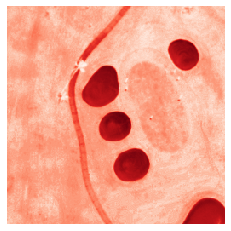

Image in category golfcourse


In [ ]:
#Using RasterIO & Creating Our Image Numpy Arrays

index = 135
src = rasterio.open(train_image_path[index])
red = src.read(1) #2D Array of shape (256, 256)
green = src.read(2)
blue = src.read(3)
RGB_array = src.read() #3D Array of shape (3, 256, 256)

train_images = np.array( [rasterio.open(train_image_path[i]).read(1).flatten() for i in range(len(train_image_path))] )
print("Train Images (red) Shape:", train_images.shape)

test_images = np.array( [rasterio.open(test_image_path[i]).read(1).flatten() for i in range(len(test_image_path))] )
print("\nTest Images (red) Shape:", test_images.shape)

# Converting the train_labels and test_labels to numpy arrays of integers (uint8), 
# where each integer represents the respective category of each image
train_labels_cat = pd.Series(train_labels, dtype="category") #There are 21 possible categories
train_labels = np.array(train_labels_cat.cat.codes)
train_labels = train_labels.astype(np.uint8)
print("\nTrain Labels (red) Shape:", train_labels.shape)

test_labels_cat = pd.Series(test_labels, dtype="category")
test_labels = np.array(test_labels_cat.cat.codes)
test_labels = test_labels.astype(np.uint8)
print("\nTest Labels (red) Shape:", test_labels.shape)

some_digit_image = test_images[index].reshape(256, 256)
plt.imshow(some_digit_image, cmap = 'Reds', interpolation="nearest")
plt.axis("off")
plt.show()
print(f"Image in category {class_names[test_labels[index]]}")

In [ ]:
def identify_train_print(num): #This function helps us see training images with their labels, for validation
    
    if num > (len(train_image_path)-1):
        num = (len(train_image_path)-1)
    elif num < 0:
        num = 0
        
    print("-- Image " + str(num) +  " in the set is in the category of \'" 
          + str(class_names[train_labels[num]]) + "\'")

    img = plt.imread(train_image_path[num])
    plt.imshow(img)
    plt.axis("off")
    plt.show()

In [ ]:
#Dimensionality Reduction
#Reshaping train_images to 28*28, rather than 256*256

i_shape = 28
pca = PCA(n_components = i_shape**2)
images_newDim = pca.fit_transform(train_images)
train_images = images_newDim

print("Train Images Shape:", train_images.shape)

Train Images Shape: (1641, 784)


In [ ]:
##------------------------Now to Classify----------------------------------##

-- Image 55 in the set is in the category of 'beach'


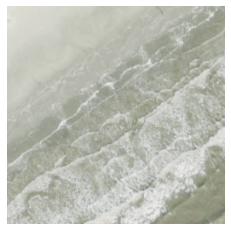

SGD Classifier Predicted Value:
[False]
SGD Classifier Accuracy Array: 
[0.38025594 0.3857404  0.36014625]


In [ ]:
#Training a SGD Classifier

image_ind = 55 #We pick the image which we predict

i = 0
found = False
while not found:
    if test_labels[i] == train_labels[image_ind]:
        found = True
    i += 1

y_train = (train_labels == train_labels[image_ind]) # True for all images of the category
y_test = (test_labels == test_labels[i])
some_digit = train_images[image_ind].reshape(1, train_images[image_ind].shape[0])

from sklearn.linear_model import SGDClassifier
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(train_images, pd.Series(y_train))

from sklearn.model_selection import cross_val_score

identify_train_print(image_ind)
print("SGD Classifier Predicted Value:")
print(sgd_clf.predict(some_digit))
print("SGD Classifier Accuracy Array: ")
print(cross_val_score(sgd_clf, train_images, pd.Series(y_train), cv=3, scoring="accuracy"))

In [ ]:
#Training a Random Forest Classifier

from sklearn.ensemble import RandomForestClassifier
rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, n_jobs=-1)

rnd_clf.fit(pd.DataFrame(train_images), pd.Series(y_train))

print("RFC Predicted Value:")
print(rnd_clf.predict(some_digit))
print("RFC Accuracy Array: ")
print(cross_val_score(rnd_clf, train_images, pd.Series(y_train), cv=3, scoring="accuracy"))


RFC Predicted Value:
[False]
RFC Accuracy Array: 
[0.95429616 0.95795247 0.95612431]


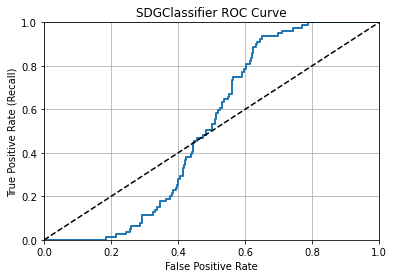

SDGClassifier ROC AUC Score: 0.517269323651923


In [ ]:
#ROC Curve with the SGD Classfier

from sklearn.model_selection import cross_val_predict
from sklearn.metrics import precision_score, recall_score

y_scores = cross_val_predict(sgd_clf, train_images, pd.Series(y_train), cv=3,
method="decision_function")

from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(pd.Series(y_train), y_scores)

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0, 1]); plt.ylim([0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate (Recall)')
    plt.title("SDGClassifier ROC Curve")
    plt.grid(True)
    
plot_roc_curve(fpr, tpr)
plt.show()

from sklearn.metrics import roc_auc_score
roc_score = roc_auc_score(pd.Series(y_train), y_scores)
print('SDGClassifier ROC AUC Score:', roc_score)

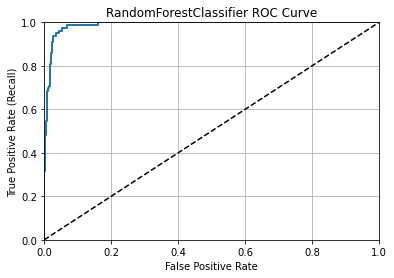

RandomForestClassifier ROC AUC Score: 0.9886140780239551
-- This seems to be a good classifier


In [ ]:
#ROC Curve with the Random Forest Classfier

y_probas_forest = cross_val_predict(rnd_clf, train_images, pd.Series(y_train), cv=3,
method="predict_proba")

y_scores_forest = y_probas_forest[:, 1]

fpr, tpr, thresholds = roc_curve(pd.Series(y_train), y_scores_forest)

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0, 1]); plt.ylim([0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate (Recall)')
    plt.title("RandomForestClassifier ROC Curve")
    plt.grid(True)
    
plot_roc_curve(fpr, tpr)
plt.show()
roc_score = roc_auc_score(pd.Series(y_train), y_scores_forest)  
print('RandomForestClassifier ROC AUC Score:', roc_score)
if roc_score >= 0.90:
    print("-- This seems to be a good classifier?")

In [ ]:
#Preparing variables for Neural Network
train_images = np.array( [train_images[i].reshape(28,28) for i in range(len(train_images))] )
print("Train Images Shape:", train_images.shape)

X_valid, X_train = train_images[:200] / 255.0, train_images[200:] / 255.0
y_valid, y_train = train_labels[:200], train_labels[200:]

print("\nX_valid.shape :", X_valid.shape)
print("X_train.shape : ", X_train.shape)
print("y_valid.shape : ", y_valid.shape)
print("y_train.shape : ", y_train.shape)

Train Images Shape: (1641, 28, 28)

X_valid.shape : (200, 28, 28)
X_train.shape :  (1441, 28, 28)
y_valid.shape :  (200,)
y_train.shape :  (1441,)


In [ ]:
#Building and Training the Neural Network

model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28, 28]))
model.add(keras.layers.Dense(300, activation="relu"))
model.add(keras.layers.Dense(21, activation="softmax"))

print(model.summary())

model.compile(loss="none", optimizer="sgd", metrics=["accuracy"])

model.compile(loss="sparse_categorical_crossentropy",optimizer="sgd",metrics=["accuracy"])
history = model.fit(X_train, y_train, epochs=30, validation_data=(X_valid, y_valid))

Model: "sequential_40"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_40 (Flatten)        (None, 784)               0         
                                                                 
 dense_116 (Dense)           (None, 300)               235500    
                                                                 
 dense_117 (Dense)           (None, 21)                6321      
                                                                 
Total params: 241,821
Trainable params: 241,821
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/30
42/42 [==============================] - 1s 11ms/step - loss: 3.7597 - accuracy: 0.1141 - val_loss: 3.2990 - val_accuracy: 0.1450
Epoch 2/30
42/42 [==============================] - 0s 7ms/step - loss: 2.6220 - accuracy: 0.2655 - val_loss: 3.0297 - val_accuracy: 0.1650
Epoch 3/30
42/42 [=======

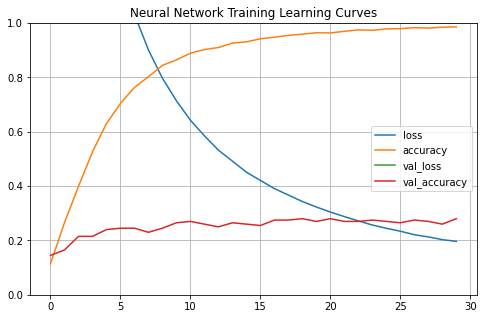

In [ ]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.title("Neural Network Training Learning Curves")
plt.show()
